<font color='blue'> Привет. Извини за долгую проверку. Ниже мои комментарии выделены синим. </font>

# Аналитика в Яндекс.Афише

**Описание проекта**

Задача - помочь маркетологам Яндекс.Афиши оптимизировать маркетинговые затраты.
В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

**Описание данных**

Таблица `/datasets/visits_log.csv` - это лог сервера с информацией о посещениях сайта:
  -  **Uid** — уникальный идентификатор пользователя
  -  **Device** — категория устройства пользователя
  -  **Start Ts** — дата и время начала сессии
  -  **End Ts** — дата и время окончания сессии
  -  **Source Id** — идентификатор рекламного источника, из которого пришел пользователь
  
Таблица `/datasets/orders_log.csv` содержит информацию о заказах:
  -  **Uid** — уникальный id пользователя, который сделал заказ
  -  **Buy Ts** — дата и время заказа
  -  **Revenue** — выручка Яндекс.Афиши с этого заказа
  
Таблица `/datasets/costs.csv` содержит информацию о затратах на маркетинг:
  -  **source_id** — идентификатор рекламного источника
  -  **dt** — дата
  -  **costs** — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta 
import datetime
import seaborn as sns

### Шаг 1: Подготовка данных к анализу

-  [Загрузим данные о визитах, заказах и расходах в переменные.](#1.1)
-  [Оптимизируем данные для анализа.](#1.2)
-  [Убедимся, что тип данных в каждой колонке — правильный.](#1.3)

 <a name="1.1"> Загрузим данные о визитах, заказах и расходах в переменные: </a>

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Изучим данные в них:

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.head(3)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
orders.head(3)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [8]:
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


In [9]:
type(costs.loc[0,'dt'])

str

Пропусков нет.  <a name="1.3"> Даты имеют строковый тип, поменяем его на тип `datetime`(перед этим избавимся от пробелов в именах колонок и приведем их к нижнему регистру):</a>

In [10]:
visits.columns = [c.lower().replace(' ', '_') for c in visits.columns]
orders.columns = [c.lower().replace(' ', '_') for c in orders.columns]

In [11]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

<a name="1.2"> В дальнейшем для анализа полезно выделить в отдельные столбцы год, месяц и неделю, а также полную дату сессии из таблицы `visits`.</a> 

In [12]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year

<font color='blue'> Хорошо, данные готовы к анализу. </font>

### Шаг 2: Отчеты и метрики

[**Продукт**](#.1)

- Сколько людей пользуются 
     -   [в день,](#2.1.1)
     -   [неделю,](#2.1.2)
     -   [месяц](#2.1.3)?
- [Сколько сессий в день?](#2.2)
- [Сколько длится одна сессия?](#2.3)
- [Как часто люди возвращаются?](#2.4)

[**Продажи**](#.2)

- [Когда люди начинают покупать?](#2.5)
- [Сколько раз покупают за период?](#2.6)
- [Какой средний чек?](#2.7)
- [Сколько денег приносят? (LTV)](#2.8)

[**Маркетинг**](#.3)
- [Сколько денег потратили? Всего / на каждый источник / по времени](#3.1)
- [Сколько стоило привлечение одного покупателя из каждого источника?](#3.2)
- [На сколько окупились расходы? (ROI)](#3.3)


###  <a name=".1">  Анализ продукта  </a>

Рассмотрим активных пользователей в трех измерениях: DAU, WAU и MAU.

 <a name="2.1.1">Изучим пользовательскую активность по дням (DAU):  </a>

In [13]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})
dau.rename(columns={'uid':'n_users'}, inplace=True)

Отрисовку графика обернем в функцию, она понадобится еще много раз в проекте:

In [14]:
def plot_graph(attribute, attribute_name, x_min, x_max, y_min, y_max):
    fig = attribute.plot(figsize=(12, 6),   lw=1, alpha=1, cmap="Set2")
    plt.tick_params(axis='x', rotation=30)
    plt.minorticks_on()
    month = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 
         'октябрь', 'ноябрь', 'декабрь']
    if (x_min != '') and (x_max != ''):
        plt.xlim(x_min, x_max)
        
    else:
        if (type(attribute.index[0]) != np.int64)& (type(attribute.index[0]) != np.int64):
            x_min = pd.to_datetime(attribute.index).min()
            x_max = pd.to_datetime(attribute.index).max()
            plt.xlim(x_min, x_max)
    if (y_min != '') and (y_max != ''):
        plt.ylim(y_min, y_max)        
    if len(plt.xticks()[0])>10:
        plt.grid(linestyle='--', which='major',
         axis='y',
         color='grey', alpha=.3)
    else:
        plt.grid(linestyle='--', which='major',
                 color='grey', alpha=.3)
    plt.grid(which='minor', color = 'grey', 
             linestyle = '--', alpha=.3)
    plt.xlabel(attribute.index.name)
    if (type(attribute.index[0]) != np.int64)& (type(attribute.index[0]) != np.int64):
        plt.title(f'{attribute_name} за период с {pd.to_datetime(x_min).strftime("%d-%m-%Y")}\
     по {pd.to_datetime(x_max).strftime("%d-%m-%Y")}')
    else:
        if len(attribute)<=12:
            plt.axvspan(6, 9, color='lightgreen', alpha=0.5)
            plt.xticks(attribute.index , month)
        else:
            plt.axvspan(22, 36, color='lightgreen', alpha=0.5)
        plt.tick_params(axis='x', rotation=0)
        plt.title(f' {attribute_name} ')
    if (len(attribute.index)<40) & \
       (type(attribute.index) == pd.core.indexes.datetimes.DatetimeIndex):
        plt.xticks(attribute.index.strftime("%b %Y"), 
                   attribute.index.strftime("%b %Y"))   
        plt.xlabel(attribute.index.name)
    plt.show()

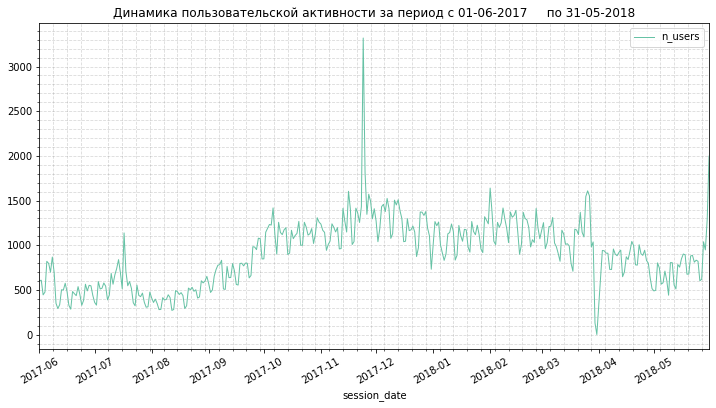

In [15]:
plot_graph(dau, 'Динамика пользовательской активности', '', '', '', '')

Пользовательсткая активность колеблется в течение месяца, и, похоже, колебания кореллируют с неделями месяца. Рассмотрим произвольный месяц поподробнее, перед этим выделим выходные дни в июне 2017 г..

In [16]:
june_weekends = dau.copy()
june_weekends = june_weekends.reset_index()
june_weekends['session_date'] =  pd.to_datetime(june_weekends.reset_index()['session_date'])
june_weekends['weekday'] = june_weekends['session_date'].dt.weekday
june_weekends['month'] = june_weekends['session_date'].dt.month
june_weekends = june_weekends[((june_weekends['weekday'] == 5)|
                               (june_weekends['weekday'] == 6))
                              &(june_weekends['month']==6)]
june_weekends = june_weekends.reset_index(drop=True)
june_weekends

,session_date,n_users,weekday,month
0,2017-06-03,445,5,6
1,2017-06-04,476,6,6
2,2017-06-10,350,5,6
3,2017-06-11,292,6,6
4,2017-06-17,328,5,6
5,2017-06-18,285,6,6
6,2017-06-24,328,5,6
7,2017-06-25,383,6,6


Построим график пользовательской активности в июне 2017 года, выделим выходные для наглядности:

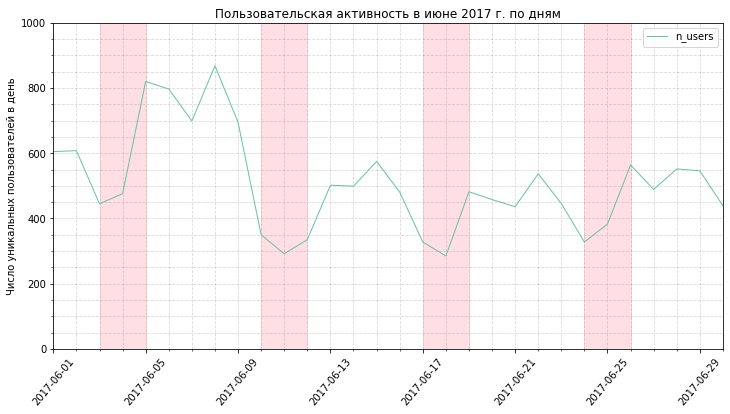

In [17]:
dau.plot (figsize=(12, 6), lw=1, alpha=1, cmap="Set2")
for i in june_weekends.index:
    if june_weekends.loc[i, 'weekday']==5:
        x_1 = june_weekends.loc[i, 'session_date']
    if june_weekends.loc[i, 'weekday']==6:
        x_2 = june_weekends.loc[i, 'session_date']    
        plt.axvspan(x_1, x_2 + timedelta(days=1), color='pink', alpha=0.5)
plt.tick_params(axis='x', rotation=50)
plt.xlim('2017-06-01', '2017-06-30')
plt.ylim(0, 1000)
plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Пользовательская активность в июне 2017 г. по дням')
plt.xlabel('')
plt.ylabel('Число уникальных пользователей в день')
plt.show()

Действительно, активность пользователей падает в выходные. Пик пользовательской активности приходится на четверг.

По статистике одного года трудно судить, есть ли сезонность по временам года в активности пользователей - наблюдаемое увеличение DAU может быть связано с ростом популярности продукта. Но из истории продукта "Яндекс.Афиша" на Википедии известно, что в последний раз полный перезапуск сервис пережил в 2015 году, а запущен был намного раньше, то есть к 2017 году уже приобрел свою аудиторию. То есть есть основания полагать, что мы наблюдаем сезонные колебания в активности пользователей (экто касается именно визитов на сайт, а не покупок): рост активности пользователей осенью, зимой и весной, летом продукт вострабован меньше. 

Также можно увидеть пик пользовательской активности, который пришелся на ноябрь 2017 года. Рассмотрим подробнее и попытаемся выяснить, что могло стать причиной резкого увеличения числа пользователей в этот период.

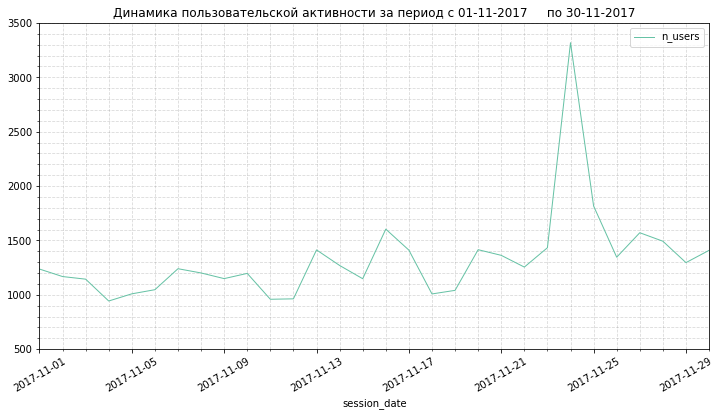

In [18]:
plot_graph(dau, 'Динамика пользовательской активности', '2017-11-01', '2017-11-30', 500, 3500)

Пик пришелся на 24 ноября, Черную пятницу. Видимо, множество новых пользователей были привлечены сервисом благодаря эффективному маркетингу. 

А вот в конце марта - начале апреля пользовательсткая активность падала до минимума за год. Попробуем выяснить, почему:

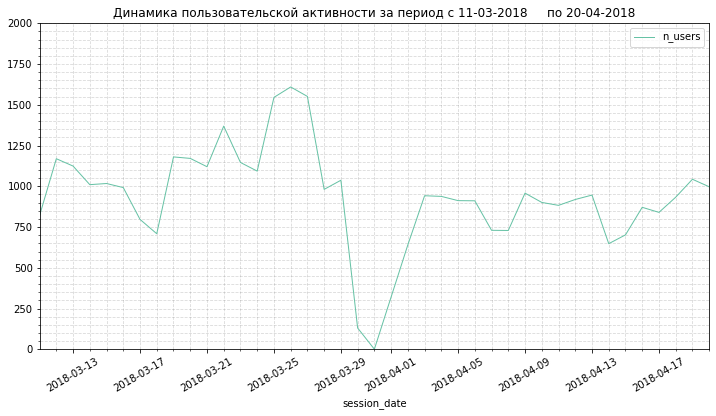

In [19]:
plot_graph(dau, 'Динамика пользовательской активности', '2018-03-11', '2018-04-20', 0, 2000)

Рассмотрим статистику визитов в период 29.03-03.04 подробнее:

In [20]:
dau[(dau.index >= pd.to_datetime('2018-03-29'))&(dau.index <= pd.to_datetime('2018-04-03'))]  

,n_users
session_date,
2018-03-29,1037
2018-03-30,131
2018-03-31,1
2018-04-02,641
2018-04-03,942


30,31 марта и 1 апреля показывают удивительное падение активности пользователей. При этом в день накануне активность пользователей была высокой, и вернулась к нормальному значению 2-3 апреля, что не позволяет нам считать такое падение результатом неудачной выгрузки данных, при которой потерялась информация за 30 марта-1 апреля. Возможно, причина в неполадках на сайте - возможно, сервис был недоступен. Посмотрим, какая статистика за 31 марта и 1 апреля присутствует в таблицах `visits`, `orders`, `costs`:

In [21]:
visits[(visits['session_date'] >= pd.to_datetime('2018-03-30'))&
       (visits['session_date'] <= pd.to_datetime('2018-04-01'))]  

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year
955,touch,2018-03-30 09:30:00,2,2018-03-30 09:29:00,8449287177195820231,2018-03-30,13,3,2018
1113,desktop,2018-03-30 09:06:00,2,2018-03-30 08:56:00,13550809671577320145,2018-03-30,13,3,2018
3540,touch,2018-03-30 09:00:00,5,2018-03-30 08:31:00,4007335129342806664,2018-03-30,13,3,2018
6587,desktop,2018-03-30 07:16:00,3,2018-03-30 07:15:00,2570623718737686982,2018-03-30,13,3,2018
8338,desktop,2018-03-30 00:34:00,4,2018-03-30 00:30:00,13396700822264973785,2018-03-30,13,3,2018
...,...,...,...,...,...,...,...,...,...
354270,touch,2018-03-30 07:36:00,2,2018-03-30 07:06:00,10203284965226984791,2018-03-30,13,3,2018
356966,desktop,2018-03-30 00:47:00,2,2018-03-30 00:36:00,8992862899587060870,2018-03-30,13,3,2018
358328,touch,2018-03-30 08:33:00,3,2018-03-30 08:22:00,2388332646007936709,2018-03-30,13,3,2018
358415,touch,2018-03-30 09:24:00,2,2018-03-30 09:24:00,10203284965226984791,2018-03-30,13,3,2018


In [22]:
orders['session_date'] = orders['buy_ts'].dt.date
orders[(orders['session_date'] >= pd.to_datetime('2018-03-30'))&
       (orders['session_date'] <= pd.to_datetime('2018-04-01'))] 

,buy_ts,revenue,uid,session_date
42780,2018-03-30 00:00:00,0.73,9132626503120023298,2018-03-30
42781,2018-03-30 00:32:00,3.67,17761512180008175765,2018-03-30
42782,2018-03-30 01:13:00,0.87,11715877101707439703,2018-03-30
42783,2018-03-30 01:14:00,3.67,9320521711110318802,2018-03-30
42784,2018-03-30 01:41:00,3.50,9320521711110318802,2018-03-30
42785,2018-03-30 01:43:00,3.91,3079123346339569491,2018-03-30
42786,2018-03-30 01:43:00,0.87,11715877101707439703,2018-03-30
42787,2018-03-30 07:15:00,0.82,2570623718737686982,2018-03-30
42788,2018-03-30 07:21:00,1.34,10203284965226984791,2018-03-30
42789,2018-03-30 08:20:00,0.92,1973134623382122814,2018-03-30


In [23]:
costs[(costs['dt'] >= pd.to_datetime('2018-03-30'))&
      (costs['dt'] <= pd.to_datetime('2018-04-01'))] 

,source_id,dt,costs
302,1,2018-03-30,6.98
665,2,2018-03-30,15.08
1028,3,2018-03-30,39.26
1391,4,2018-03-30,15.69
1754,5,2018-03-30,25.50
1755,5,2018-03-31,0.70
2118,9,2018-03-30,1.85
2481,10,2018-03-30,1.99


Наше мини-расследование показало, что сервис Яндекс.Афиши перестал быть доступен 30 марта после 9.30 утра, 31 марта сайт посетил 1 человек (возможно, технический специалист), 1 апреля сайт продолжал "лежать", и заработал только 2 апреля. Но вернемся к DAU: в рассчете среднего количества уникальных пользователей в день необходимо исключить дни, на которые пришлелся сбой в работе сервиса, иначе они исказят статистику по DAU:

In [24]:
visits_ = visits[(visits['session_date'] < 
              pd.to_datetime('2018-03-30'))|
             (visits['session_date'] > 
              pd.to_datetime('2018-04-02'))].copy()
dau = visits_.groupby('session_date').agg({'uid':'nunique'})
dau.rename(columns={'uid':'n_users'}, inplace=True)
dau_total = dau.mean()
dau_spring = (visits_[visits_['session_month'].isin([3,4,
                                                     5])].groupby('session_date').agg({'uid':
                                                                          'nunique'})).mean()
dau_summer = (visits_[visits_['session_month'].isin([6,7,
                                                   8])].groupby('session_date').agg({'uid':
                                                                          'nunique'})).mean()
dau_autumn = (visits_[visits_['session_month'].isin([9,10,
                                                   11])].groupby('session_date').agg({'uid':
                                                                            'nunique'})).mean()
dau_winter = (visits_[visits_['session_month'].isin([12,1,
                                                   2])].groupby('session_date').agg({'uid':
                                                                           'nunique'})).mean()

Рассчитаем среднее количество уникальных пользователей в день за год, и в каждый из сезонов:

In [25]:
print('Среднее количество уникальных пользователей в день: ', int(dau_total))
print('Среднее количество уникальных пользователей в день весной: ', int(dau_spring))
print('Среднее количество уникальных пользователей в день летом: ', int(dau_summer))
print('Среднее количество уникальных пользователей в день осенью: ', int(dau_autumn))
print('Среднее количество уникальных пользователей в день зимой: ', int(dau_winter))

Среднее количество уникальных пользователей в день:  913
Среднее количество уникальных пользователей в день весной:  917
Среднее количество уникальных пользователей в день летом:  491
Среднее количество уникальных пользователей в день осенью:  1067
Среднее количество уникальных пользователей в день зимой:  1183


Даже без проверок на статистическую значимость очевидна разница - летом аудитория сервиса уменьшается вдвое по сравнению с осенне-зимними месяцами.

 <a name="2.1.2">Изучим пользовательскую активность по неделям (WAU):  </a>

На этот раз необходимо удалить статистику недели, на которую пришелся сбой в работе сервиса. Выясним номер недели, на которой произошел сбой:

In [26]:
visits[(visits['session_date'] >= 
              pd.to_datetime('2018-03-30'))&
             (visits['session_date'] < 
              pd.to_datetime('2018-04-02'))]['session_week'].value_counts()

13    135
Name: session_week, dtype: int64

Это была 13 неделя - несчастливое для Яндекс.Афиши число! Удалим данные по этой неделе и подсчитаем WAU:

In [27]:
visits_copy = visits[visits['session_week'] !=  13]
wau = visits_copy.groupby('session_week').agg({'uid':'nunique'})
wau.rename(columns={'uid':'n_users'}, inplace=True)
wau_total = wau.mean()
wau_spring = (visits_copy[visits_copy['session_month'].isin([3,4,5])].groupby('session_week').agg({'uid':
                                                                          'nunique'})).mean()
wau_summer = (visits_copy[visits_copy['session_month'].isin([6,7,8])].groupby('session_week').agg({'uid':
                                                                          'nunique'})).mean()
wau_autumn = (visits_copy[visits_copy['session_month'].isin([9,10,11])].groupby('session_week').agg({'uid':
                                                                            'nunique'})).mean()
wau_winter = (visits_copy[visits_copy['session_month'].isin([12,1,2])].groupby('session_week').agg({'uid':
                                                                           'nunique'})).mean()

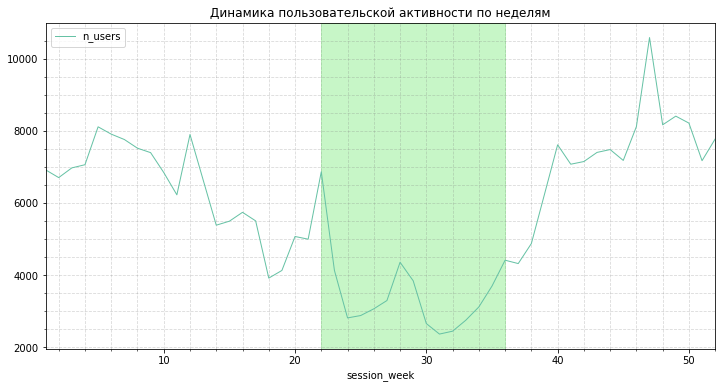

In [28]:
plot_graph(wau, 'Динамика пользовательской активности по неделям', '', '', '', '')

Подсветили летниие недели года, видим, что именно в эти недели активность пользователей снижается до минимума - кроме пика, пришедшегося на середину июля. Присутствует сезонность - начиная с первых недель лета активность пользователей падает, ненадолго повышаясь в середине лета, и возвращаяст постепенно к сентябрю-октябрю до "доотпускных" значений. Рассчитаем среднее количество уникальных пользователей в неделю за год, и в каждый из сезонов:

In [29]:
print('Среднее количество уникальных пользователей в неделю: ', int(wau_total))
print('Среднее количество уникальных пользователей в неделю весной: ', int(wau_spring))
print('Среднее количество уникальных пользователей в неделю летом: ', int(wau_summer))
print('Среднее количество уникальных пользователей в неделю осенью: ', int(wau_autumn))
print('Среднее количество уникальных пользователей в неделю зимой: ', int(wau_winter))

Среднее количество уникальных пользователей в неделю:  5842
Среднее количество уникальных пользователей в неделю весной:  5405
Среднее количество уникальных пользователей в неделю летом:  3001
Среднее количество уникальных пользователей в неделю осенью:  6367
Среднее количество уникальных пользователей в неделю зимой:  6951


Почти уникальных 6000 пользователей в неделю! А летом в два раза меньше.. Похоже, маркетологи летом тоже отдыхают.

 <a name="2.1.3">Наконец, рассмотрим пользовательскую активность по месяцам (MAU): </a>

В данном случае целесообразно поправить статистику за март-апрель 2018г., так как иначе отсутствующая вследствие сбоя сервиса статистика исказит MAU. Мы уже выяснили по дням, как обстояла ситуация с посещениями сайта в дни технического сбоя. Дополним статистику по соответствующему месяцу в соответствии со средним значением пользовательской активности весной - просто прибавим пользователей, которые пришли бы на сайт, не случись сбой (не забудем вычесть ту неполную статистику, которая попала в общую):

In [30]:
mau = visits.groupby('session_month').agg({'uid':'nunique'})
mau.rename(columns={'uid':'n_users'}, inplace=True)

dau_ = visits.groupby('session_date').agg({'uid':'nunique'}).reset_index()

mau.loc[3,'n_users'] = mau.loc[3,'n_users'] + int(dau_spring)*2 - \
                       dau_[dau_['session_date']==pd.to_datetime('2018-03-30')]['uid'].sum() \
                       - dau_[dau_['session_date']==pd.to_datetime('2018-03-31')]['uid'].sum()

mau.loc[4,'n_users'] = mau.loc[4,'n_users'] + + int(dau_spring)*2 - \
                       dau_[dau_['session_date']==pd.to_datetime('2018-04-01')]['uid'].sum() \
                       - dau_[dau_['session_date']==pd.to_datetime('2018-04-02')]['uid'].sum()
 

mau_total = mau.mean()
mau_spring = (visits[visits['session_month'].isin([3,4,5])].groupby('session_month') \
                                                           .agg({'uid':'nunique'})).mean()
mau_summer = (visits[visits['session_month'].isin([6,7,8])].groupby('session_month') \
                                                           .agg({'uid':'nunique'})).mean()
mau_autumn = (visits[visits['session_month'].isin([9,10,11])].groupby('session_month') \
                                                             .agg({'uid':'nunique'})).mean()
mau_winter = (visits[visits['session_month'].isin([12,1,2])].groupby('session_month') \
                                                            .agg({'uid':'nunique'})).mean()

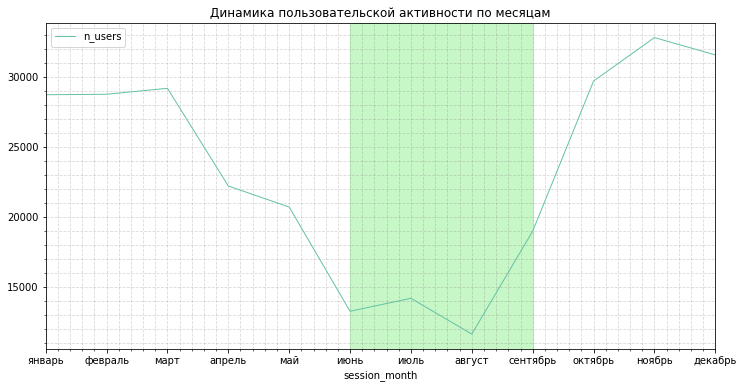

In [31]:
plot_graph(mau, 'Динамика пользовательской активности по месяцам', '', '', '', '')

Еще одна иллюстрация к сезонности спроса на контент сервиса. Минимум пользовательской активности приходится на август, максимум - на ноябрь (благодаря Черной пятнице). Рассчитаем среднее количество уникальных пользователей в месяц за год, и в каждый из сезонов:

In [32]:
print('Среднее количество уникальных пользователей в месяц: ', int(mau_total))
print('Среднее количество уникальных пользователей в месяц весной: ', int(mau_spring))
print('Среднее количество уникальных пользователей в месяц летом: ', int(mau_summer))
print('Среднее количество уникальных пользователей в месяц осенью: ', int(mau_autumn))
print('Среднее количество уникальных пользователей в месяц зимой: ', int(mau_winter))

Среднее количество уникальных пользователей в месяц:  23469
Среднее количество уникальных пользователей в месяц весной:  23060
Среднее количество уникальных пользователей в месяц летом:  13024
Среднее количество уникальных пользователей в месяц осенью:  27154
Среднее количество уникальных пользователей в месяц зимой:  29674


<font color='blue'> Отлично, очень подробный анализ. </font>

 <a name="2.2">Рассчитаем среднее количество сессий в день и сравним со средним числом уникальных пользователей в день: </a>

In [33]:
sess_per_user = visits_.groupby('session_date').agg({'start_ts':'count', 'uid':'nunique'})
sess_per_user.rename(columns={'start_ts':'n_sessions', 'uid':'n_users' }, inplace=True)
sess_per_user['sessions_per_user'] = sess_per_user['n_sessions']/sess_per_user['n_users']

In [34]:
print('Среднее количество сессий в день: ', int(sess_per_user['n_sessions'].mean())) 
print('Среднее количество уникальных пользователей в день:',  int(sess_per_user['n_users'].mean()))
print('Сессий на человека в день:', "{0:.2f}".format(sess_per_user['sessions_per_user'].mean()))

Среднее количество сессий в день:  993
Среднее количество уникальных пользователей в день: 913
Сессий на человека в день: 1.08


Подавляющее большинство пользователей не заходит на сайт Афиши повторно в течение дня. Но маленький процент пользователей возвращается в течение дня, уточним, сколько именно:

In [35]:
session_per_user = visits_.groupby(['session_date','uid']).agg({'start_ts':'count'})
users_return = session_per_user[session_per_user['start_ts'] >= 2].reset_index()
return_users_per_day = users_return.groupby('session_date').agg({'uid':'nunique'})
return_users_per_day_total = return_users_per_day.mean()
print("{0:.1%}".format(int(return_users_per_day_total)/int(dau_total)), 
      ' пользователей возвращается в течение дня')

6.8%  пользователей возвращается в течение дня


Интересно также выяснить, сколько сессий приходится на одного пользователя за месяц - это хороший показатель регулярности использования приложения:

In [36]:
sessions_per_user = visits_.groupby(['session_year', 
                                     'session_month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions']/ \
                                         sessions_per_user['n_users']
print(sessions_per_user.mean())
print('Среднее количество сессий в месяц: ', int(sessions_per_user['n_sessions'].mean())) 
print('Среднее количество уникальных пользователей в месяц:',  int(sessions_per_user['n_users'].mean()))
print('Сессий на человека в месяц:', "{0:.2f}".format(sessions_per_user['sessions_per_user'].mean()))

n_sessions           29881.833333
n_users              23177.083333
sessions_per_user        1.280745
dtype: float64
Среднее количество сессий в месяц:  29881
Среднее количество уникальных пользователей в месяц: 23177
Сессий на человека в месяц: 1.28


In [37]:
sess_per_user_month = visits_.groupby(['session_month','uid']).agg({'start_ts':'count'})
users_return_month = sess_per_user_month[sess_per_user_month['start_ts'] >= 2].reset_index()
return_users_per_month = users_return_month.groupby('session_month').agg({'uid':'nunique'})
return_users_per_month_total = return_users_per_month.mean()
print("{0:.1%}".format(int(return_users_per_month_total)/int(mau_total)), 
      ' пользователей возвращается в течение месяца')

14.3%  пользователей возвращается в течение месяца


Если рассматривать пользовательсткую активность в разрезе месяца, то видим, что более 85% пользователей используют сервис не чаще раза в месяц, только 14.3% пользователей показывают пользовательсткую активность выше. Есть с чем работать маркетологам!

 <a name="2.3"> Найдем среднюю длительность одной сессии - ASL (average session length):  </a>

In [38]:
visits_['session_duration_sec'] = (visits_['end_ts'] - visits_['start_ts']).dt.seconds
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [39]:
len(visits_[visits_['session_duration_sec']==0])

35708

Обнаружилось более 35 тысяч сессий длительностью 0 секунд. Логично считать, что сессия длиной 0 секунд - это неосуществленная сессия, и информацию о таких сессиях рассматривать в статистике не нужно.

In [40]:
visits_ = visits_[visits_['session_duration_sec']!=0]
visits = visits[visits['session_duration_sec']!=0]

Рассмотрим распределение длительности сессий:

In [41]:
def hist_graph(attribute, x_min, x_max):
    plt.figure(figsize=(10, 5))
    plt.hist(attribute, bins=200, ec='black', alpha = 1, color='powderblue')
    plt.grid(True, linestyle='--', color='grey', alpha=.3)
    plt.title('')
    if (x_min != '')&(x_max != ''):
        plt.xlim(x_min, x_max)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

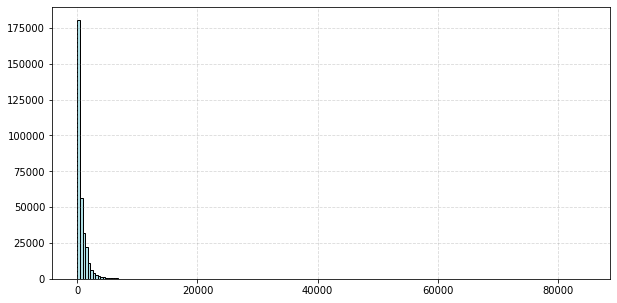

In [42]:
hist_graph(visits_['session_duration_sec'], '', '')

В данном случае для рассчета средней длительности одной сессии целесообразно рассматривать моду, так как ввиду характера распределения ни медиана, ни среднее не будут показательны.

In [43]:
print(int(visits_['session_duration_sec'].mode()), 
      ' секунд чаще всего проводит пользователь на сайте Афиши')

60  секунд чаще всего проводит пользователь на сайте Афиши


Также можно сравнить, как отличается среднее время, проведенное на сервисе, в зависимости от платформы:

In [44]:
print(int(visits_[visits_['device']=='touch']['session_duration_sec'].mean()), 
      ' секунд чаще всего проводит пользователь на сайте Афиши с мобильного устройства')
print(int(visits_[visits_['device']=='desktop']['session_duration_sec'].mean()), 
      ' секунд чаще всего проводит пользователь на сайте Афиши со стационарного устройства')

548  секунд чаще всего проводит пользователь на сайте Афиши с мобильного устройства
773  секунд чаще всего проводит пользователь на сайте Афиши со стационарного устройства


 <a name="2.3"> Выясним, как часто пользователи обращаются к сервису - рассчитаем sticky factor ("Степень вовлечения"):  </a>

In [45]:
sticky_mau = (int(dau_total) / int(mau_total))
sticky_wau = (int(dau_total) / int(wau_total))
print("{0:.1%}".format(sticky_wau))
print("{0:.1%}".format(sticky_mau))

15.6%
3.9%


<font color='blue'> Все верно. </font>

Рассчитаем Retention Rate посетителей сервиса:

In [46]:
first_session_date = visits.groupby('uid')['start_ts'].min()
first_session_date.name = 'first_session_date'
visits = visits.merge(first_session_date, on='uid')
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

In [47]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')
visits['cohort_lifetime'] = (visits['session_month'] - visits['first_session_month'])/ \
                            np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

<font color='blue'> здесь что-то пошло не так. </font>

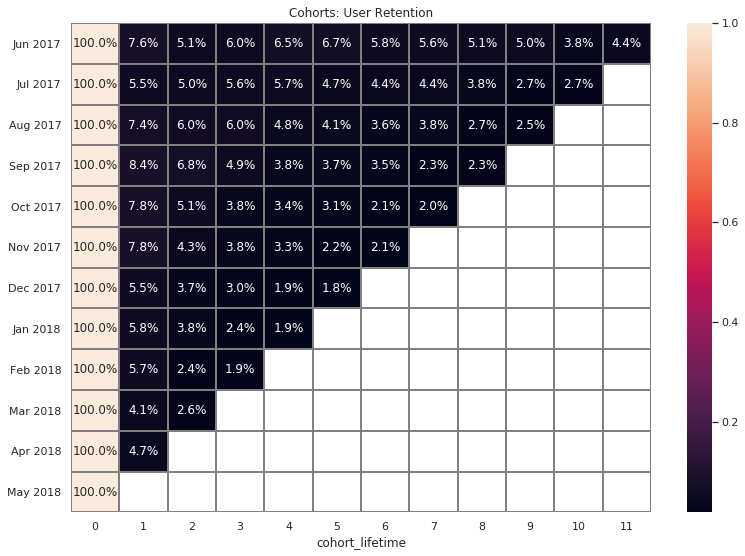

In [48]:
cohorts = visits.groupby(['first_session_month',
                          'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month',
                                                               'uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(inital_users_count,on='first_session_month')
cohorts
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_session_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')
retention_pivot.index = retention_pivot.index.strftime('%b %Y')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');


Можно также посчитать Churn Rate, хотя можно догадаться, каков будет результат.

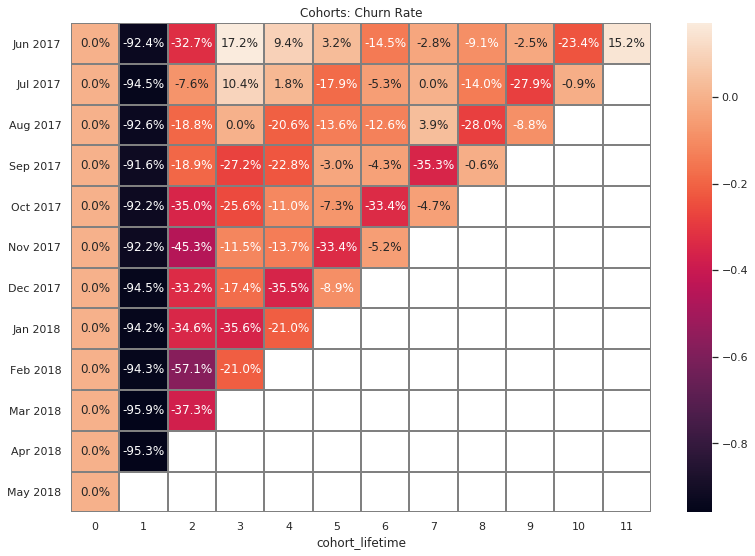

In [49]:
cohorts['churn_rate'] = cohorts.groupby(['first_session_month'])['uid'].pct_change()
churn_pivot = cohorts.pivot_table(index='first_session_month',
                                  columns='cohort_lifetime',
                                  values='churn_rate',
                                  aggfunc='sum')
churn_pivot.index = churn_pivot.index.strftime('%b %Y')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Churn Rate')
sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Утверждать, что отток пользователей именно такой, как мы рассчитали, нельзя, так как существует проблема cookie, которые периодически стираются пользователем, и старый пользователь получает новый id в нашей статистике. Но можно предполагать, что все-таки отток достаточно высокий, и у сервиса есть проблемы с удержанием пользователя.

<font color='blue'>Retention который был получен (без учета ошибки кода) рассчитан не верно. Постарайся сделать последовательно. Сначало посчитай количество визитов в каждой когорте, а затем в цикле подели количество визитов в каждом месяце когорты на количество визитов в предыдущий месяц <font color='red'>ошибочка, да по отношению к 0 месяцу. </font> . Пропусков в  retention быть не должно. </font>

<font color='blue'>Churn рассчитывать не надо, это только загромождает проект, retention достаточно. </font> 

<font color='blood'> Спасибо за фидбек, исправила ошибку в коде. Не уверена, что правильно поняла комментарий - я считаю Retention Rate как отношение количества пользователей в текущем месяце жизни когорты к количеству пользователей в начальный момент (как это сформулировано в спринте - вот [формула](https://pictures.s3.yandex.net/resources/rr_1572436473.jpg)). А Churn Rate как раз показывает разницу между месяцами жизни когорты. Возможно, вместе они читаются нагляднее. На всякий случай оставила и Churn Rate.
 </font>
 
 
<font color='red'> Retention рассчитан верно. Да, в комментарии про рассчет не корректно написала, извини. Что касается churn и retention? для каждого конкретного случая используется какой-то один параметр. В данном случае это retention, он обычно используется для анализа визита на сайты, вход в игру и.т.п. Churn rate чаще используют для сервисов с подписчиками, а также сотовые операторы и.т.п. </font> 

###  <a name=".3"> Анализ продаж  </a>

 <a name="2.5"> Следующим шагом выясним, в какой момент люди начинают покупать: </a>

Извлечем из таблицы `visits` информацию для каждого пользователя о дате первой сессии:

In [50]:
first_session_date = visits.groupby('uid')['start_ts'].min().reset_index() 

Извлечем из таблицы `orders` информацию для каждого пользователя о дате первой покупки:

In [51]:
first_order_date = orders.groupby('uid')['buy_ts'].min().reset_index()

Соединим две таблицы и добавим столбец с информацией о времени, прошедшем с момента начала первой сессии до первой произведенной покупки:

In [52]:
first_session_order = first_session_date.merge(first_order_date, how='outer', on='uid')
first_session_order['int_time'] = first_session_order['buy_ts'] - \
                                  first_session_order['start_ts']
first_session_order['int_time_sec'] = first_session_order['int_time'].dt.seconds
first_session_order['int_time_day'] = first_session_order['int_time'].dt.days

Рассчитаем среднее время, прошедшее с момента начала первой сессии до момента покупки - в часах:

In [53]:
avg_time = first_session_order['int_time_sec'].mean()/(3600)
print(f'Среднее время, прошедшее с момента начала первой сессии до момента покупки {avg_time:.2} часа')

Среднее время, прошедшее с момента начала первой сессии до момента покупки 4.0 часа


In [54]:
first_day_order = len(first_session_order[first_session_order['int_time_day'] == 0.0]) \
 / len(first_session_order[~first_session_order['buy_ts'].isnull()])
print(f'В первый день совершают покупки {first_day_order:.0%} от всех покупателей')

В первый день совершают покупки 72% от всех покупателей


Интересно найти ту же самую величину для разных когорт:

In [55]:
first_session_order['first_session_month'] = first_session_order['start_ts'] \
                                                    .astype('datetime64[M]')

Когортой в данном случае является месяц, в котором произошла первая сессия пользователя.

In [56]:
cohort_grouped = first_session_order.groupby('first_session_month') \
                                    .agg({'int_time_sec':'mean', 'uid':'nunique'})
cohort_grouped['int_time_hours'] = cohort_grouped['int_time_sec']/3600
print(cohort_grouped)

                     int_time_sec    uid  int_time_hours
first_session_month                                     
2017-06-01           17850.000000  11885        4.958333
2017-07-01           17761.400584  11825        4.933722
2017-08-01           16729.652695   9214        4.647126
2017-09-01           17661.609578  15125        4.906003
2017-10-01           14581.290743  23538        4.050359
2017-11-01           16689.505938  24852        4.635974
2017-12-01           14151.513648  23030        3.930976
2018-01-01           14292.229796  20573        3.970064
2018-02-01           12412.191011  20173        3.447831
2018-03-01           10465.648213  18793        2.907125
2018-04-01           10951.158117  14215        3.041988
2018-05-01            8099.203426  13828        2.249779


Время возврата пользователя за покупкой в каждой следующей когорте имеет тенденцию к сокращению. Что логично, так как в последние когорты вошли только те покупатели, которые вернулись быстро - то есть, в последнюю когорту, например, вошли только те, кто сделал покупку в том же месяце, когда впервые зашел на Яндекс.Афишу. Точнее всего оценить среднее время, прошедшее с момента первой сессии до момента покупки, можно только спустя  несколько месяцев с момента формирования когорты.

Итак, выяснили, что чаще всего покупателями становятся в первый же день знакомства с сервисом. Но до покупки доходит далеко не каждый пользователь. Выясним, какова средняя конверсия - какой % от всех пользователей совершили покупку:

In [57]:
conversion = first_session_order['buy_ts'].count()/first_session_order['start_ts'].count()
print(f'Средняя конверсия пользователя в покупателя составляет {conversion:.0%}')

Средняя конверсия пользователя в покупателя составляет 18%


Интересно посмотреть на динамику конверсии по месяцам:

In [58]:
#first_session_order['first_session_month'] = first_session_order['start_ts'].dt.month
first_session_order['first_session_date_month'] = first_session_order['start_ts'] \
                                                         .astype('datetime64[M]')
first_session_order['first_order_month'] = first_session_order['buy_ts'].dt.month
first_session_order['first_order_date_month'] = first_session_order['buy_ts'] \
                                                         .astype('datetime64[M]')
conversion_month = first_session_order.groupby('first_session_month') \
                                      .agg({'buy_ts':'count', 'start_ts':'count'})
conversion_monthly = first_session_order.groupby('first_session_date_month') \
                                      .agg({'buy_ts':'count', 'start_ts':'count'})
conversion_month['conversion'] = conversion_month['buy_ts'] / conversion_month['start_ts']
conversion_monthly['conversion'] = conversion_monthly['buy_ts']    \
                                   / conversion_monthly['start_ts']

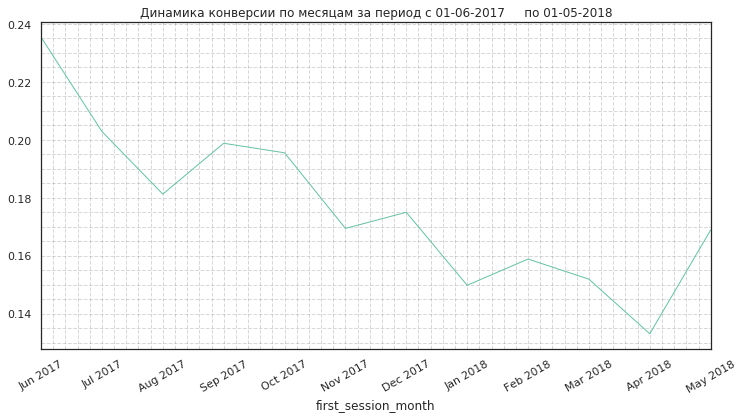

In [59]:
plot_graph(conversion_month['conversion'], 'Динамика конверсии по месяцам', '', '', '', '')

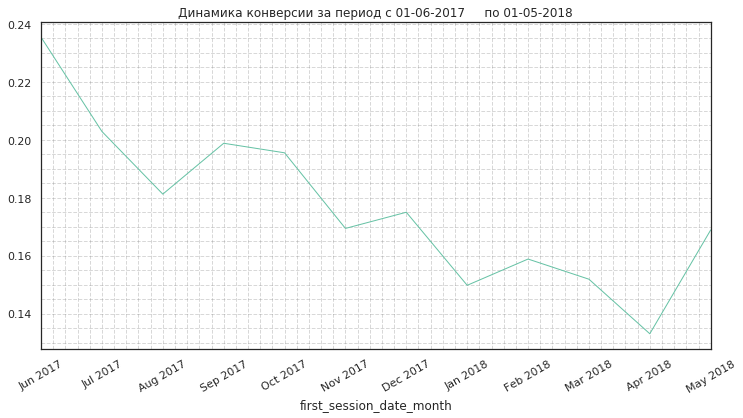

In [60]:
plot_graph(conversion_monthly['conversion'], 'Динамика конверсии','','','','')

Анализ обоих графиков показывает сезонность, которой обладает конверсия - в мае она растет, а в июне достигает своего пика. Летом к сервису обращается меньше пользователей, но они чаще совершают покупки.

<font color='blue'>отлично. </font>

 <a name="2.6"> Сколько раз покупают за период?  </a>

Исследуем динамику продаж по месяцам:

In [61]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [62]:
orders_dyn = orders.groupby('order_month').agg({'uid':'count', 'revenue':'sum'})
orders_dyn.rename(columns={'uid':'n_users'}, inplace=True)
orders_dyn

,n_users,revenue
order_month,,
2017-06-01,2354,9557.49
2017-07-01,2363,12539.47
2017-08-01,1807,8758.78
2017-09-01,3387,18345.51
2017-10-01,5679,27987.70
2017-11-01,5659,27069.93
2017-12-01,6218,36388.60
2018-01-01,4721,19417.13
2018-02-01,5281,25560.54


В статистике с продажами обнаружился июнь 2018 года с 1 покупателем. Очевидно, он попал в выборку случайно, статистика за июнь 2018 года не полная. Уберем эти данные из рассмотрения.

In [63]:
orders = orders[orders['order_month'] != '2018-06-01']

In [64]:
purchases = orders.groupby(['uid', 'order_month']).agg({'buy_ts':'count', 'revenue':'sum'})
purchases.rename(columns={'buy_ts':'orders_count'}, inplace=True)
purchases_per_month = purchases.groupby('uid').agg({'orders_count':'mean', 'revenue':'sum'})
purchases_per_month.rename(columns={'orders_count':'mean_orders_count'}, inplace=True)
purchases['orders_count'].max()

67

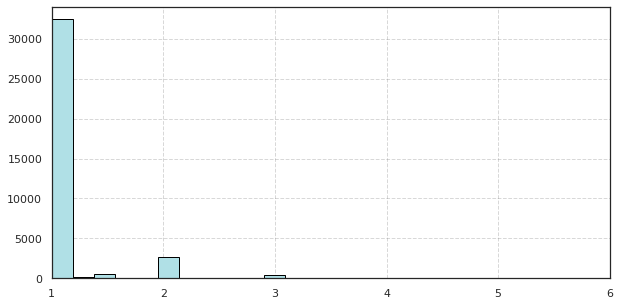

In [65]:
hist_graph(purchases_per_month['mean_orders_count'], 1, 6)

Большая часть пользователей, совершивших покупку, делает это не чаще раза в месяц. Но есть настоящие фанаты Афиши - 67 покупок за месяц у какого-то из пользователей! Познакомимся с нашим рекордсменом:

In [66]:
record = purchases['orders_count'].max()
id_record = purchases[purchases['orders_count']==record].index[0][0]
recordsman = orders[orders['uid'] == id_record] 
record_orders = recordsman.groupby('session_date').agg({'revenue':'sum', 'buy_ts':'count'})
record_orders.rename(columns={'buy_ts':'orders_count'}, inplace=True)

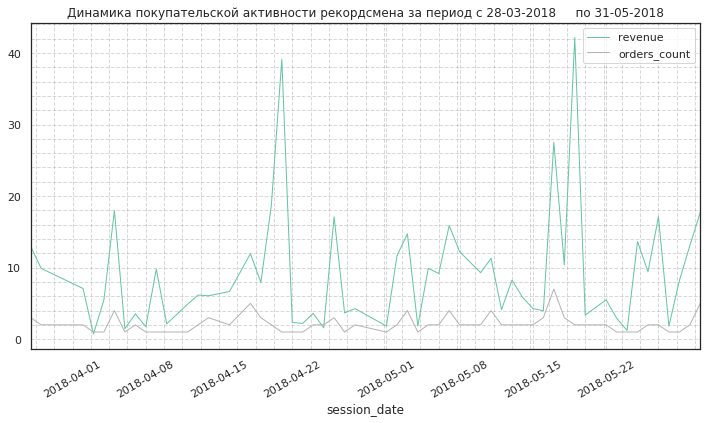

In [67]:
plot_graph(record_orders, 'Динамика покупательской активности рекордсмена','','','','')

In [68]:
print('В среднем в день ', "{0:.2f}".format(record_orders['orders_count'].mean()), ' покупок')
print('Максимально ', record_orders['orders_count'].max(), ' покупок в день')

В среднем в день  2.13  покупок
Максимально  7  покупок в день


Покупатель мечты! Есть надежда, что этот преданный и фанатичный покупатель остался с Афишей надолго - его история кончается в моменте среза, то есть у нас нет информации о том, ушел ли он, и снизилась ли его покупательсткая активность. Было бы интересно исследовать характерные признаки этого клиента и тех, кто близок к нему по поведению, и использовать эту информацию в маркетинговых акциях. Звучит, как задача для Data Scientist'а. Но мы отвлеклись.. Вернемся к анализу.

In [69]:
purchases_dynamics = purchases.groupby('order_month').agg({'orders_count':'mean', 
                                                           'revenue':'sum'})

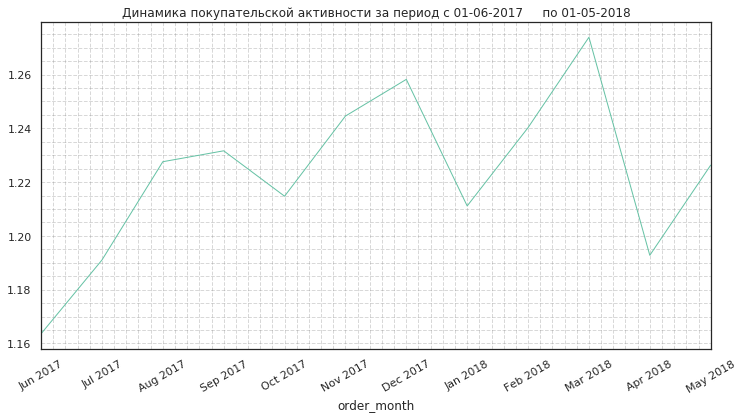

In [70]:
plot_graph(purchases_dynamics['orders_count'], 'Динамика покупательской активности', 
                                               '2017-06-01','2018-05-01','','')

Покупательская активность показывает всплеск в декабре, марте и мае - можно предполагать, что это связано с праздниками, приходящимися на эти периоды.

<font color='blue'>Все верно. </font>

 <a name="2.7">Посчитаем средний чек. </a>

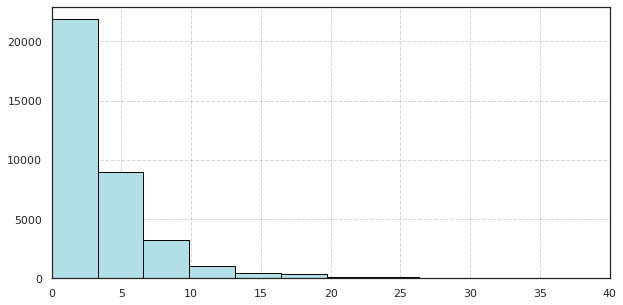

In [71]:
avg_check = orders.groupby('uid').agg({'revenue':'sum', 'buy_ts':'count'})
avg_check.rename(columns={'buy_ts':'orders_count'}, inplace=True)
avg_check['avg_revenue'] = avg_check['revenue'] / avg_check['orders_count'] 
hist_graph(avg_check['avg_revenue'], 0, 40)

In [72]:
avg_check['avg_revenue'].mean()

4.093111317489109

Средний чек покупателя составляет ~ 4.1 условные единицы.

<font color='blue'>Хорошо, все верно. </font>

Рассчитаем средний чек в разрезе когорт:

In [73]:
first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders.join(first_order_date_by_customers,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [74]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month',
                                            'order_month']).agg({'revenue':'sum',
                                                                 'uid':'nunique'})
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / \
                                                orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - \
                                               orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] /\
                                               np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] \
                                               .round().astype('int')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month']\
                                               .dt.strftime('%Y-%m')
check_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month', 
                                                    columns='cohort_lifetime',
                                                    values='revenue_per_user',
                                                    aggfunc='mean')

<font color='blue'> Здесь также что-то пошло не так. </font>

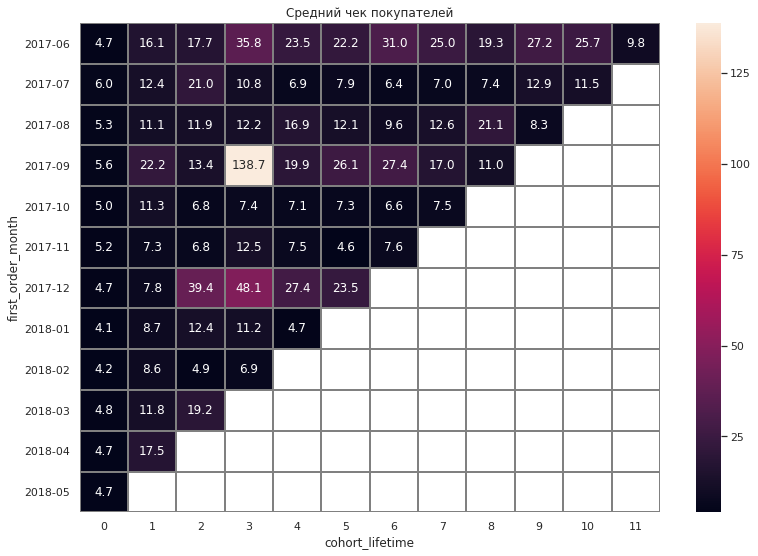

In [75]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(check_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

<font color='blue'> Чек рассчитан не верно. Скорее всего  использован count вместо nunique. </font>

<font color='blood'> Действительно, я использовала count, ориентируясь на комментарий преподавателя в Slack в треде про средний чек:
> "В рамках нашего проекта нужно рассчитывать средний чек как среднее по всем чекам (через count)."

Переделала. </font>

<font color='red'> Ок. В целом в проекте вполне достаточно среднего чека без учета когорт, который рассчитан чуть выше, только жедательно посмотреть динамику его изменения по времени. </font> 

 <a name="2.8"> Узнаем, сколько денег приносят пользователи сервиса (рассчитаем LTV): </a>

In [76]:
ltv = orders.groupby('uid').agg({'revenue':'sum'})
ltv.mean()

revenue    6.901423
dtype: float64

Сформируем когорты по дате первой покупки на сайте и рассматорим LTV в разрезе когорт:

In [77]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohorts = orders.groupby(['first_order_month',
                          'order_month']).agg({'revenue': 'sum'}).reset_index()

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


В разбивке LTV по месяцам жизни когорты видим, что основную lifetime value клиенты приносят в первый месяц, когда начинают покупать. Можно было бы выводить LTV накопительным итогом, но тогда было бы труднее сравнивать разницу в приносимой в каждый месяц value. Например, сейчас мы можем наблюдать, что у первой, июньской когорты, дела обстоят лучше, чем, например, у последующей июльской. Качество аудитории в июльской (и, например, в ноябрьской) когорте упало - аудитория этих когорт в последующем мало возвращалась за покупками. 

In [78]:
ltv_cohorts = report.groupby('first_order_month').agg({'revenue':'sum', 'n_buyers':'mean'})
ltv_cohorts['ltv'] = ltv_cohorts['revenue'] / ltv_cohorts['n_buyers']
ltv_cohorts

,revenue,n_buyers,ltv
first_order_month,,,
2017-06-01,24031.69,2023,11.879234
2017-07-01,16127.92,1923,8.386854
2017-08-01,11606.26,1370,8.471723
2017-09-01,34676.32,2581,13.435227
2017-10-01,27603.45,4340,6.360242
2017-11-01,26098.99,4081,6.395244
2017-12-01,33485.74,4383,7.639913
2018-01-01,16663.13,3373,4.940151
2018-02-01,16750.50,3651,4.587921


Хотя сравнивать абсолютные значения LTV разных когорт не корректно, так как LTV будет тем меньше, чем моложе когорта, но рассматривая LTV по каждой из когорт, видим подтверждение наших наблюдений - июльская и августовская когорты оказались не такими прибыльными, как июньская и сентябрьская - которая по LTV превзошла более "старую" июньскую когорту. Кроме того, можно видеть, что январская и февральская когорты также не отличились качеством аудитории - более молодые мартовская и апрельская когорты их обошли по LTV.

<font color='blue'> Хорошо. </font>

###  <a name=".2">  Маркетинговый анализ  </a>

 <a name="3.1"> Выясним, сколько денег тратили на рекламу, рассмотрим затраты в динамике и в разрезе источников: </a>

In [79]:
costs.rename(columns={'dt':'date'}, inplace=True)

In [80]:
daily_costs = costs.groupby('date').agg({'costs':'sum'})

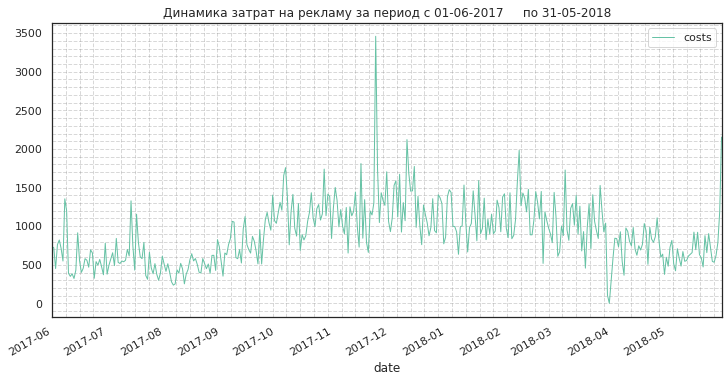

In [81]:
plot_graph(daily_costs, 'Динамика затрат на рекламу', '', '', '', '')

Видим, что в летние месяцы затраты на меркетинг ниже, чем в остальной период года. В ноябре видим абсолютный пик, что связано, очевидно, с уже исследованной нами Черной пятницей.  Также видим обратный пик в конце марта-начале апреля, что связано, как мы уже выяснили, со сбоем в работе сервиса.

In [82]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs['week'] = costs['date'].dt.week

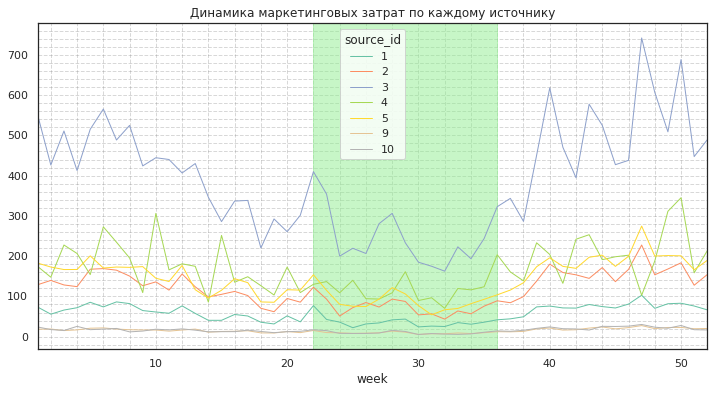

In [83]:
costs_source = costs.pivot_table(index = 'week', columns ='source_id', values = 'costs')
plot_graph(costs_source,'Динамика маркетинговых затрат по каждому источнику', '', '', '', '')

 <a name="3.2"> Посчитаем CAC  </a> (customer acquisition cost) — стоимость привлечения клиента, то есть во сколько обходится новый клиент компании.

In [84]:
cac_cohort = ltv_cohorts.reset_index()
cac_cohort.rename(columns={'first_order_month':'month'}, inplace=True)
costs_monthly = costs.groupby('month').agg({'costs':'sum'}).reset_index()
cac_cohort = pd.merge(cac_cohort, costs_monthly, on='month')

In [85]:
cac_cohort['cac'] = cac_cohort['costs'] / cac_cohort['n_buyers']
cac_cohort[['month','n_buyers', 'ltv', 'cac']].round(2)

,month,n_buyers,ltv,cac
0,2017-06-01,2023,11.88,8.91
1,2017-07-01,1923,8.39,9.49
2,2017-08-01,1370,8.47,10.80
3,2017-09-01,2581,13.44,9.44
4,2017-10-01,4340,6.36,8.37
5,2017-11-01,4081,6.40,9.29
6,2017-12-01,4383,7.64,8.74
7,2018-01-01,3373,4.94,9.94
8,2018-02-01,3651,4.59,8.96
9,2018-03-01,3533,5.46,8.61


Рассчитали  CAC  в разрезе когорт. Можно видеть, что покупатели, привлеченные в августе, обошлись компании заметно дороже, а в среднем  CAC составляет ~ 9.

<font color='blue'> Все верно. </font>

Рассмотрим стоимость привлечения одного клиента в разрезе источника, для этого напишем функцию, считающую CAC:

In [86]:
costs_source = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
#first_session_date.rename(columns={'start_ts':'first_session_date'}, inplace=True)

In [87]:
first_source = visits[visits['start_ts'] == 
                      visits['first_session_date']][['uid', 'source_id', 'device']]


In [88]:
orders = pd.merge(orders, first_source, on='uid')
orders.rename(columns={'source_id':'first_source'}, inplace=True)

def cac_source(source_id):
    cohort_sizes = orders[orders['first_source'] == 
                          source_id].groupby('first_order_month') \
                                    .agg({'uid':'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    cohorts = orders[orders['first_source'] == source_id].groupby(['first_order_month',
                              'order_month']).agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    report['age'] = (report['order_month'] - report['first_order_month']) / \
                     np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['revenue'] / report['n_buyers']
    ltv_cohorts = report.groupby('first_order_month').agg({'revenue':'sum','n_buyers':'mean'})
    ltv_cohorts['ltv'] = ltv_cohorts['revenue'] / ltv_cohorts['n_buyers']
    
    cac_cohort = ltv_cohorts.reset_index()
    cac_cohort.rename(columns={'first_order_month':'month'}, inplace=True)
    costs_monthly = costs[costs['source_id'] == source_id].groupby('month') \
                                                          .agg({'costs':'sum'}).reset_index()
    cac_cohort = pd.merge(cac_cohort, costs_monthly, on='month')
    cac_cohort['cac'] = cac_cohort['costs'] / cac_cohort['n_buyers']
    return cac_cohort[['month','n_buyers', 'ltv', 'cac']].round(2)

In [89]:
costs_monthly = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
buyers_by_sources = orders.groupby('first_source').agg({'uid':'nunique', 'revenue':'sum'}).reset_index()
buyers_by_sources.rename(columns={'uid':'n_buyers', 'first_source':'source_id'}, inplace=True)
cac = pd.merge(buyers_by_sources, costs_monthly, on='source_id')
cac['cac'] = cac['costs'] / cac['n_buyers']
cac['ltv'] = cac['revenue'] / cac['n_buyers']
cac.round(2)

,source_id,n_buyers,revenue,costs,cac,ltv
0,1,2964,30537.37,20833.27,7.03,10.30
1,2,3515,47265.19,42806.04,12.18,13.45
2,3,10248,53061.62,141321.63,13.79,5.18
3,4,10112,55597.73,61073.60,6.04,5.50
4,5,6847,53352.23,51757.10,7.56,7.79
5,9,1087,5746.85,5517.49,5.08,5.29
6,10,1306,4611.73,5822.49,4.46,3.53


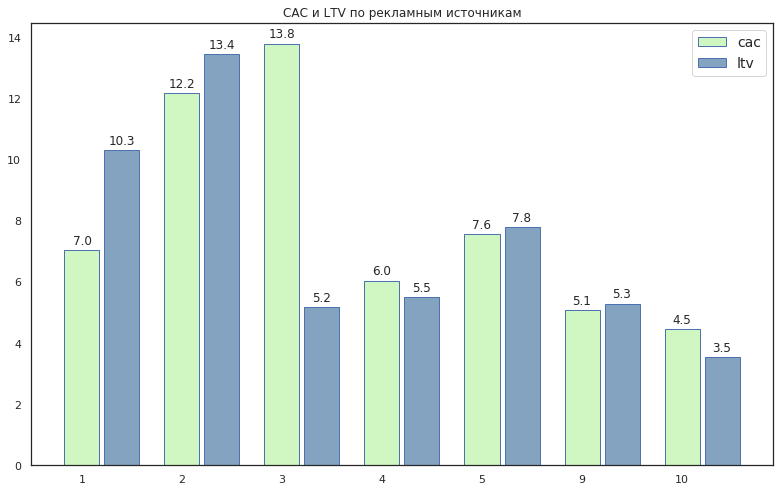

In [90]:
labels = cac['source_id']
cac_ = cac['cac']
ltv_ = cac['ltv']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

f, ax = plt.subplots(figsize=(11,7))
rects1 = ax.bar(x, cac_, width, edgecolor='b', linewidth= 1, 
                label='cac', color=(0.4, 0.9, 0.2, 0.3))
rects2 = ax.bar(x + width + 0.05, ltv_, width, edgecolor='b', linewidth= 1, 
                label='ltv', color=(0.2, 0.4, 0.6, 0.6))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('')
ax.set_title('CAC и LTV по рекламным источникам')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize = 14)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
f.tight_layout()
plt.show()

Выше всего стоимость привлечения покупателя - в источнике 3, при этом потраченный именно на этот источник бюджет - самый большой, но источник не выглядит эффективным - LTV не компенсирует затраты на привлечение через этот источник. Окупились источники 1, 5, 9. Рассмотрим вопрос окупаемости подробнее для каждого из источников.

<font color='blue'> Анализ по когортам не нужен. Просто получи CAC для каждого источника данных и отобрази на диаграмме. </font>

<font color='blood'> Переделала выше </font>

<font color='red'>Отлично. </font> 

 <a name="3.3"> Выясним, окупились ли расходы  </a> - рассчитаем ROMI:



<font color='blue'> В целом ROMI тоже не нужно по месяцам брать. Достаточно взять итоговый и посмотреть окупился ли источник. </font>

In [91]:
cac['romi'] = cac['ltv'] / cac['cac']
cac

,source_id,n_buyers,revenue,costs,cac,ltv,romi
0,1,2964,30537.37,20833.27,7.028769,10.302756,1.465798
1,2,3515,47265.19,42806.04,12.178105,13.446711,1.104171
2,3,10248,53061.62,141321.63,13.790167,5.177754,0.375467
3,4,10112,55597.73,61073.60,6.039715,5.498193,0.910340
4,5,6847,53352.23,51757.10,7.559092,7.792059,1.030820
5,9,1087,5746.85,5517.49,5.075888,5.286891,1.041570
6,10,1306,4611.73,5822.49,4.458262,3.531187,0.792055


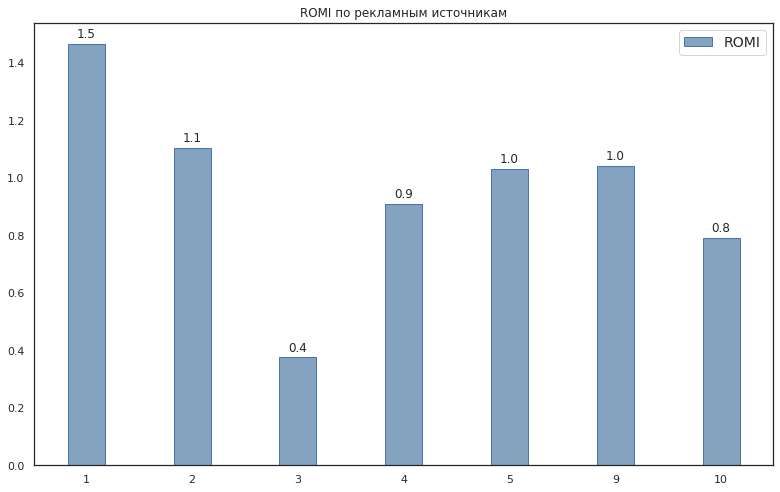

In [92]:
labels = cac['source_id']
romi = cac['romi']
x = np.arange(len(labels))  # the label locations
width = 0.35 # the width of the bars

f, ax = plt.subplots(figsize=(11,7))
rect = ax.bar(x, romi, width, edgecolor='b', linewidth= 1, 
                label='ROMI', color=(0.2, 0.4, 0.6, 0.6))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('')
ax.set_title('ROMI по рекламным источникам')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize = 14)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rect)
f.tight_layout()
plt.show()

### Шаг 3.  Вывод

Из проведенного анализа можно заключить, что маркетологам стоит устремить силы на удержание клиента, так как на данный момент отток клиентов после первой же покупки очень высокий.

Также можно порекомендовать пересмотреть затраты на маркетинг: источник 3 (и в меньшей степени 10) не выглядит эффективными, логично перенаправить средства, выделяемые на рекламу в этом источнике, на другие, более эффективные, например на источник 1.

<font color='blue'> Ты проделала хорошую работу, но где-то закралась небольшая ошибка. Постарайся исправить ошибку в коде, пересчитать retention и средний чек. Остальные замечания менее значителдьные. </font>

<font color='red'> Проект отлично долработан, молодец. </font> 